## ECBM E4040 Final Project - SWIN Transformer Implementation using Tensorflow 2.x
### Classification on CIFAR-10 Dataset

This notebook contains the code to train our tensorflow implementation of the Swin Transformer based on the paper [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030).

We train our model and evaluate the performance on the CIFAR-10 Image Classification Dataset, a popular Computer Vision benchmarking problem which is tricky due to the lower image resolution (32x32).

We start by importing necessary libraries:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os

#Disable warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

## Loading Data
We load the CIFAR-10 dataset using Tensorflow Datasets (TFDS). TFDS returns us a tf.data.Dataset instance for train/test sets which we can use for processing. Note that we use the CIFAR-10 test set as our validation set to evaluate our model's performance. We use a batch size of 64, and apply augmentations on the train set:

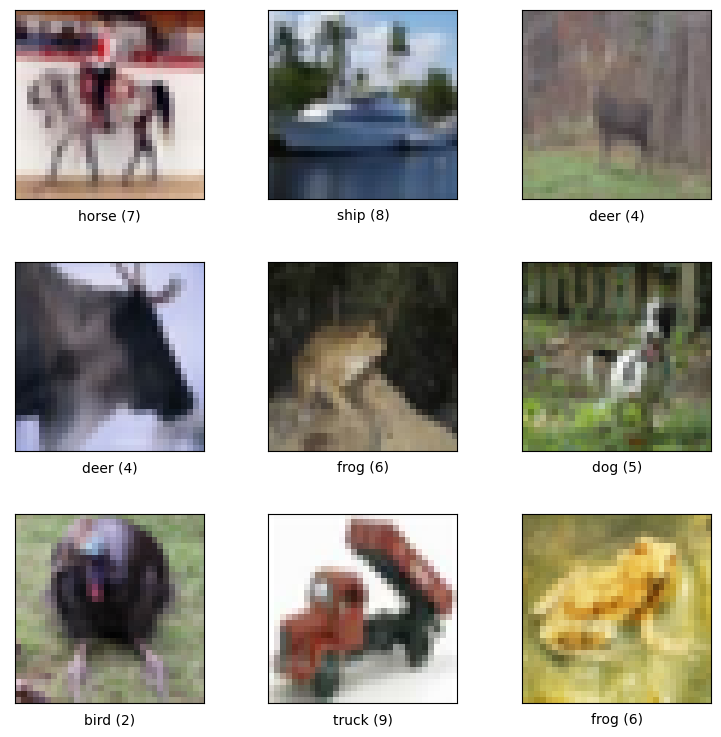

In [2]:
# Load data
batch_size = 64
img_height = 32
img_width = 32

train_ds, train_info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True)
val_ds = tfds.load('cifar10', split='test', shuffle_files=False)

# Display some images
fig = tfds.show_examples(train_ds, train_info)
plt.show()

AUTOTUNE = tf.data.AUTOTUNE

# Add data augmentations
trainAug = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.Rescaling(scale=1.0 / 255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
])
# For validation, we just use resize/rescale
valAug = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.Rescaling(scale=1.0 / 255)
])

train_ds = train_ds.map(lambda features: (trainAug(features['image']), features['label']), 
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda features: (valAug(features['image']), features['label']), 
                        num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [3]:
images, labels = next(iter(train_ds))
print(images.shape, labels.shape)

(64, 32, 32, 3) (64,)


We configure dynamic memory allocation for training on GPU:

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [5]:
num_batches = train_ds.reduce(0, lambda x,_: x+1).numpy()
print('# of batches in train set: ',num_batches)

# of batches in train set:  782


In [6]:
#Check GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Initialize Model

We define our hyperparameters and model below. We train for 35 epochs with a learning rate of $10^{-3}$. As mentioned in our report, we use the OneCycle learning rate scheduler as proposed in the paper [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120). Our lr scheduler will vary our learning rate according to the OneCycle policy. For our optimizer, we use AdamW as suggested by the authors of the SWIN Transformer paper. Our model architecture is a reduced form of Swin_T with 17M parameters (as opposed to 28M on Swin_T by the original authors):

In [7]:
input_shape = (img_height, img_width, 3)

learning_rate = 1e-3
num_epochs = 35
weight_decay = 1e-5

total_steps = int(num_epochs * num_batches)

In [8]:
from utils.model import SwinTransformer

#Define and compile model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    SwinTransformer('swin_best', fc_layer=True),#tf.keras.regularizers.L2(0.01)
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()
metric1 = tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")
metric2 = tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top3_accuracy")

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
    metrics=[metric1, metric2]
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 swin_tiny_best (SwinTransfo  (None, 1000)             17363880  
 rmerModel)                                                      
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 17,373,890
Trainable params: 17,365,186
Non-trainable params: 8,704
_________________________________________________________________


We train our model, and add callbacks for tensorboard logging, and to continuously save the best model weights based on validation accuracy:

In [ ]:
%load_ext tensorboard
import datetime
from utils.callback import OneCycleScheduler

model_name = 'Swin-cifar10'
#Callback for tensorboard logging
log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'-'+model_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#Callback for saving model checkpoints
checkpoint_filepath = 'model-checkpoints/'+model_name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#Define LR Scheduler (OneCycleScheduler)
lr_schedule = OneCycleScheduler(learning_rate, total_steps)

#Train model
history = model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[lr_schedule, tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/35
782/782 [==============================] - 428s 522ms/step - loss: 2.0334 - accuracy: 0.2309 - top3_accuracy: 0.5640 - val_loss: 1.9355 - val_accuracy: 0.3117 - val_top3_accuracy: 0.6696
Epoch 2/35
782/782 [==============================] - 406s 519ms/step - loss: 1.4544 - accuracy: 0.4691 - top3_accuracy: 0.7984 - val_loss: 1.4769 - val_accuracy: 0.4955 - val_top3_accuracy: 0.8056
Epoch 4/35
782/782 [==============================] - 406s 519ms/step - loss: 1.3162 - accuracy: 0.5240 - top3_accuracy: 0.8345 - val_loss: 1.5126 - val_accuracy: 0.5041 - val_top3_accuracy: 0.7996
Epoch 5/35
782/782 [==============================] - 406s 519ms/step - loss: 1.2360 - accuracy: 0.5543 - top3_accuracy: 0.8540 - val_loss: 1.3390 - val_accuracy: 0.5461 - val_top3_accuracy: 0.8290
Epoch 6/35
729/782 [==========================>...] - ETA: 25s - loss: 1.1795 - accuracy: 0.5778 - top3_accuracy: 0.8665

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



782/782 [==============================] - 404s 517ms/step - loss: 1.1420 - accuracy: 0.5913 - top3_accuracy: 0.8753 - val_loss: 1.2146 - val_accuracy: 0.5783 - val_top3_accuracy: 0.8515
Epoch 10/35
782/782 [==============================] - 406s 519ms/step - loss: 1.1260 - accuracy: 0.5959 - top3_accuracy: 0.8772 - val_loss: 1.1523 - val_accuracy: 0.5903 - val_top3_accuracy: 0.8710
Epoch 11/35
782/782 [==============================] - 406s 519ms/step - loss: 1.1073 - accuracy: 0.6041 - top3_accuracy: 0.8829 - val_loss: 1.1152 - val_accuracy: 0.6031 - val_top3_accuracy: 0.8865
Epoch 12/35
782/782 [==============================] - 406s 519ms/step - loss: 1.0655 - accuracy: 0.6188 - top3_accuracy: 0.8883 - val_loss: 1.1186 - val_accuracy: 0.6048 - val_top3_accuracy: 0.8855
Epoch 13/35
 30/782 [>.............................] - ETA: 6:01 - loss: 1.0760 - accuracy: 0.6125 - top3_accuracy: 0.8943

## Results

Note that our training runs in the background (since it is long-running) and the output of tensorflow may be clipped. We load the best weights of our model after training and check the performance:

In [15]:
# Load Best weights
model.load_weights(checkpoint_filepath)

In [16]:
# Re-evaluate based on best weights
metrics = model.evaluate(val_ds, verbose=2)
print("Restored model: (loss, validation accuracy, validation top-3 accuracy)\n ",metrics)

157/157 - 25s - loss: 1.3769 - accuracy: 0.7235 - top3_accuracy: 0.9324 - 25s/epoch - 159ms/step
Restored model: (loss, validation accuracy, validation top-3 accuracy)
  [1.3769152164459229, 0.7235000133514404, 0.9323999881744385]


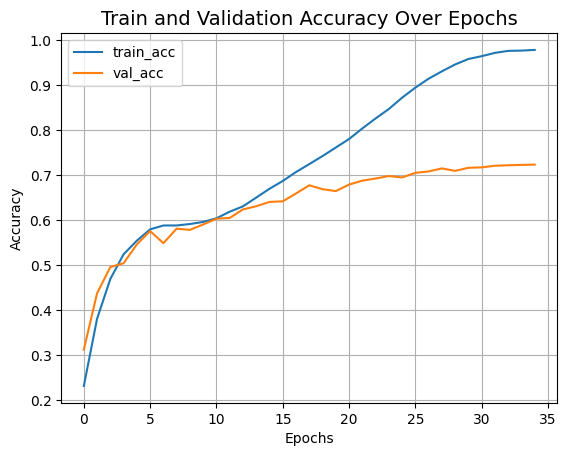

In [17]:
# Plot Accuracy Curve
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

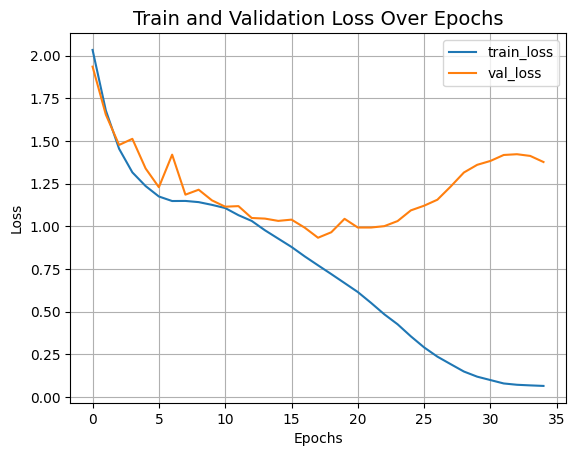

In [18]:
# Plot Loss Curve
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

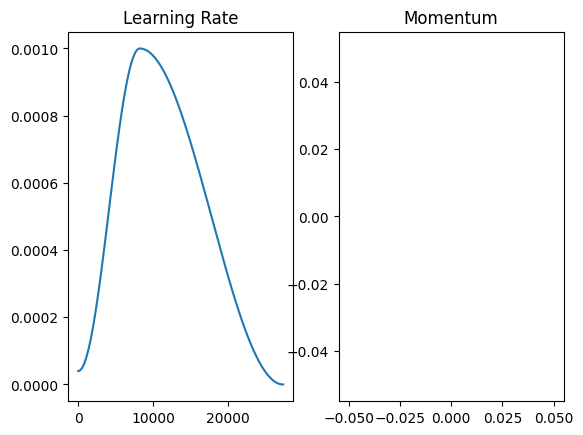

In [19]:
# Plot Learning Rate Curve from Scheduler
lr_schedule.plot()

In [24]:
# Check inference time
import time

images, labels = next(iter(val_ds))
start_time = time.time() # set the time at which inference started
model.predict(tf.expand_dims(images[0], axis=0))
stop_time = time.time()
duration = stop_time - start_time
hours = duration // 3600
minutes = (duration - (hours * 3600)) // 60
seconds = duration - ((hours * 3600) + (minutes * 60))
msg = f'Elapsed time was {seconds * 1000} ms)'
print(msg, flush=True)

1/1 [==============================] - 0s 49ms/step
Elapsed time was 82.97443389892578 ms)


We obtain a top-1 accuracy of ~73% and top-3 accuracy of ~93.2% on the validation set. Our model appears to overfit the data towards epoch 20, indicating that greater regularization should be implemented. We experimented with various learning rates, lr schedulers (cosine decay vs OneCycle), model complexities (4,4 vs 2,4,4), and L2 regularization (we observe it did not have much impact). In the next notebooks, we train other models for comparison with our Swin Transformer model.

In [25]:
# Generate tree
!sudo apt-get install tree
!tree ./ >> README.md

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following packages were automatically installed and are no longer required:
  libnuma1 linux-gcp-5.4-headers-5.4.0-1087 linux-gcp-5.4-headers-5.4.0-1089
  linux-gcp-5.4-headers-5.4.0-1092
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
